In [1]:
# SYSTEM
from os import sys, cpu_count
from time import time
from multiprocessing import Process
from multiprocessing.shared_memory import SharedMemory

# DATA TOOLS
import pickle
import numpy as np
import pandas as pd
#import scipy as sp
import scipy.stats as stats
from sklearn.preprocessing import normalize#, PolynomialFeatures
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans#, MeanShift
from sklearn.linear_model import  LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.svm import SVR

# VISUALIZATION
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# PACKAGE CONFIG
mpl.rcParams.update({'font.size':16})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('./input/train.csv')

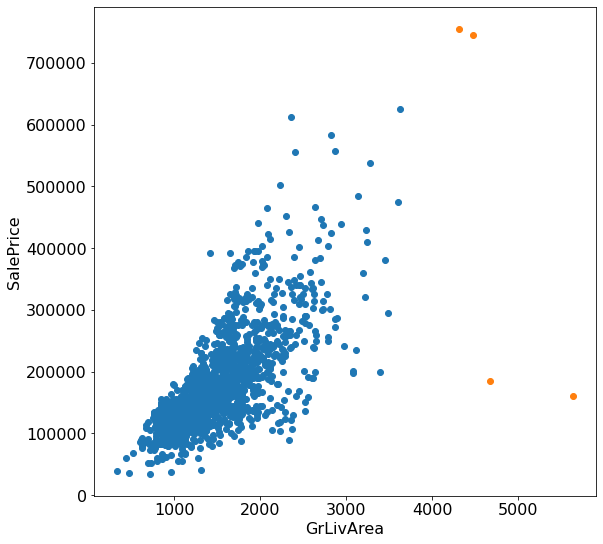

In [3]:
X = df.GrLivArea[df.GrLivArea < 4000]
y = df.SalePrice[df.GrLivArea < 4000]
Xo = df.GrLivArea[df.GrLivArea > 4000]
yo = df.SalePrice[df.GrLivArea > 4000]
plt.figure(figsize=(9,9))
plt.scatter(X,y, c = 'C0')
plt.scatter(Xo,yo, c='C1')
plt.xlabel(X.name)
plt.ylabel(y.name)
plt.show()

df = df[(df['GrLivArea'] < 4000)]

In [4]:
df['SalePrice'] = np.log1p(df['SalePrice'])
target = df['SalePrice']

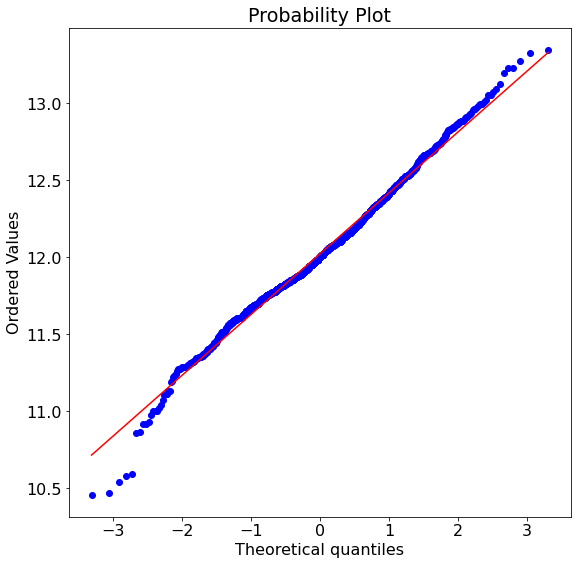

In [5]:
fig, ax = plt.subplots(figsize= (9,9))
stats.probplot(target,plot=ax)
plt.show()

# Missing Values 

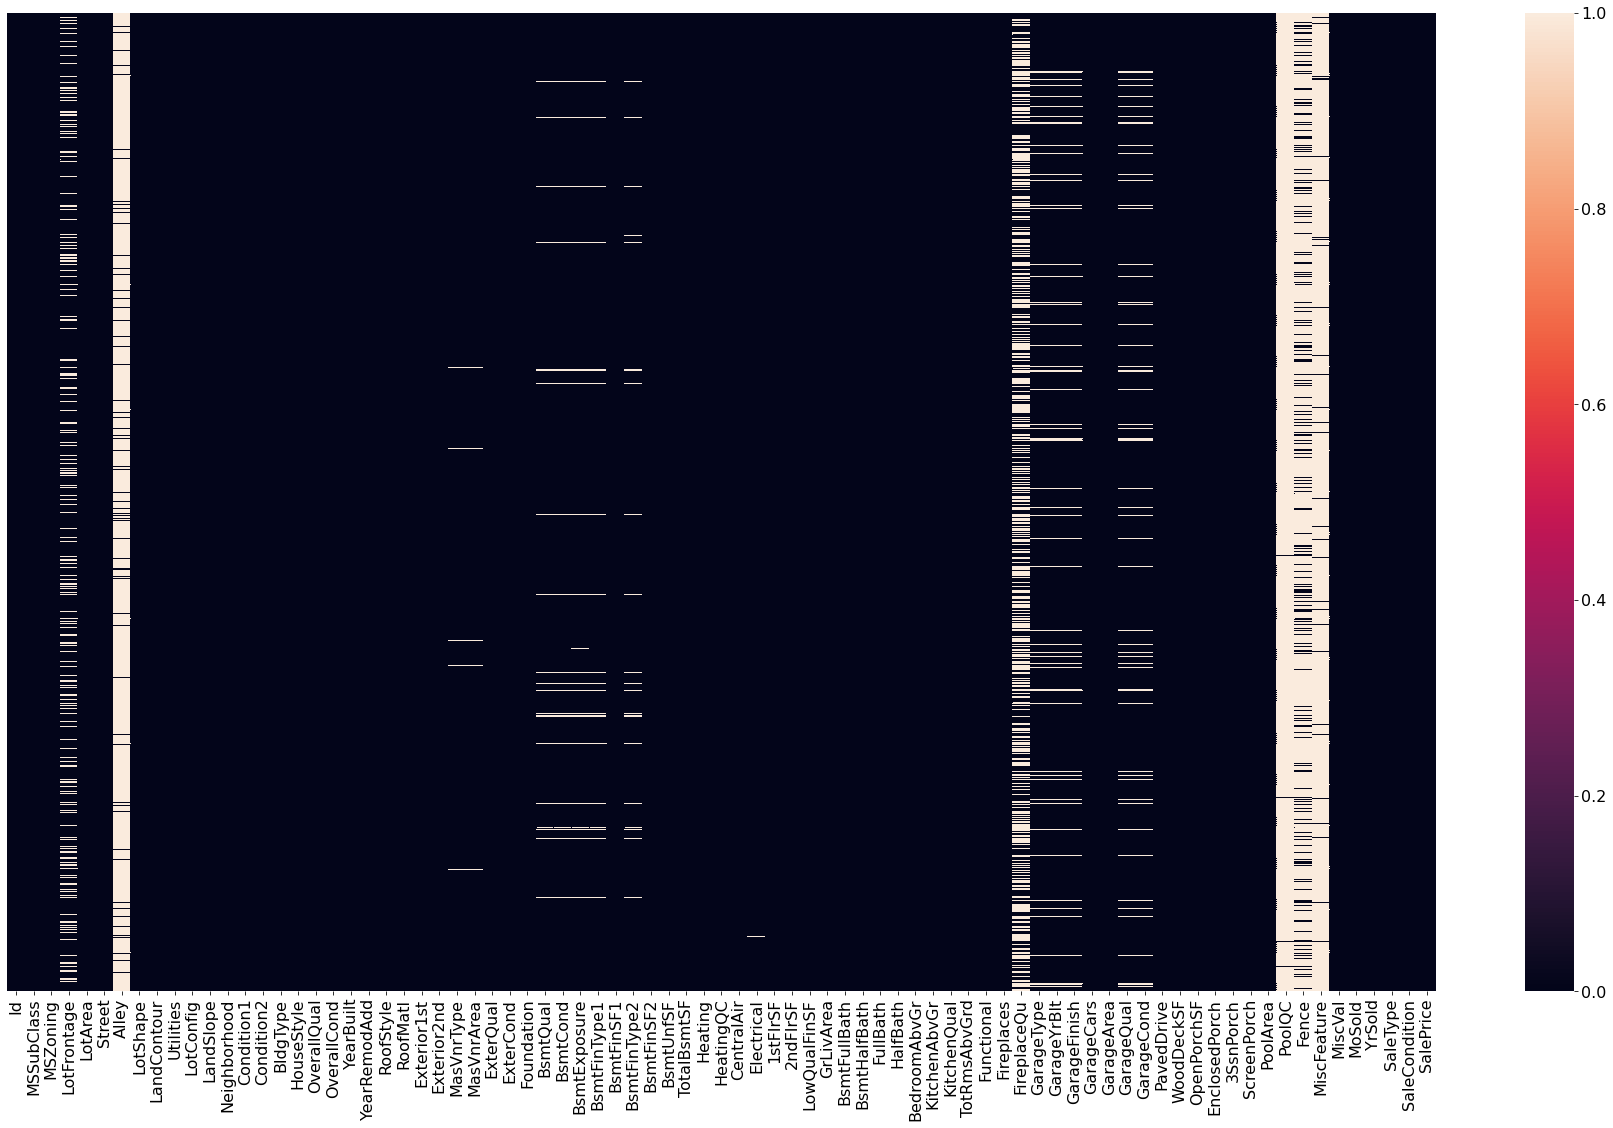

In [6]:
plt.figure(figsize=(32,18))
sns.heatmap(df.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()

In [7]:
df.columns[df.isnull().any() == True]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## Missingness

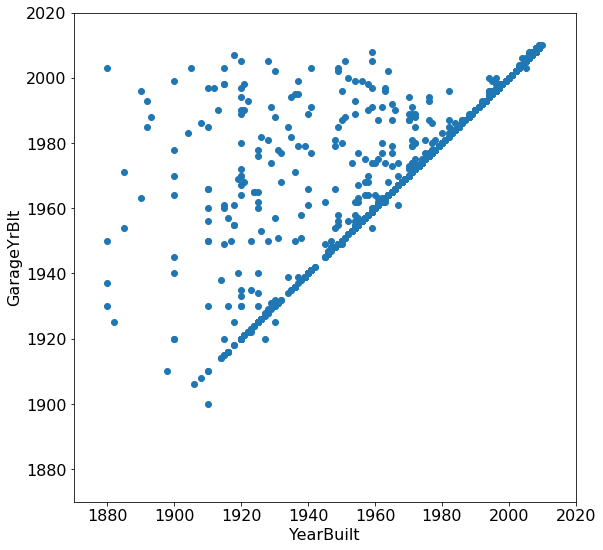

In [8]:
X = df.YearBuilt
y = df.GarageYrBlt
plt.figure(figsize=(9,9))
plt.scatter(X,y, c = 'C0')
plt.xlim(1870,2020)
plt.ylim(1870,2020)
plt.xlabel(X.name)
plt.ylabel(y.name)
plt.show()


In [9]:
df[df.GarageYrBlt.isnull() & df.GarageType.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,40,90,RL,65.000,6040,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,11.314
48,49,190,RM,33.000,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,11.635
78,79,90,RL,72.000,10778,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.824
88,89,50,C (all),105.000,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,11.350
89,90,20,RL,60.000,8070,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,11.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1350,70,RM,50.000,5250,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,11.712
1407,1408,20,RL,nan,8780,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2009,WD,Normal,11.626
1449,1450,180,RM,21.000,1533,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,11.430
1450,1451,90,RL,60.000,9000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,11.820


In [10]:
# NA probably means no frontage
df['LotFrontage'].replace(np.nan,0,inplace=True)

# NA probably means no alley
df['Alley'].replace(np.nan,'None',inplace=True)

# NA probably means no basement
df['BsmtQual'].replace(np.nan,'None',inplace=True)
df['BsmtCond'].replace(np.nan,'None',inplace=True)
df['BsmtExposure'].replace(np.nan,'None',inplace=True)
df['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df['BsmtFinType2'].replace(np.nan,'None',inplace=True)

# Replaced with feature mode
df['Electrical'].replace(np.nan,stats.mode(df['Electrical'])[0][0],inplace=True)

# NA probably means no fence
df['Fence'].replace(np.nan,'None',inplace=True)

# NA probably means no fireplaces
df['FireplaceQu'].replace(np.nan,'None',inplace=True)

# NA probably means no garage
df['GarageType'].replace(np.nan,'None',inplace=True)
df['GarageFinish'].replace(np.nan,'None',inplace=True)
df['GarageQual'].replace(np.nan,'None',inplace=True)
df['GarageCond'].replace(np.nan,'None',inplace=True)

# Best choice is not clear. 
df['GarageYrBlt'].replace(np.nan,df['YearBuilt'],inplace=True)

# NA probably means no Masonry Veneer
df['MasVnrArea'].replace(np.nan,0,inplace=True)
df['MasVnrType'].replace(np.nan,'None',inplace=True)

# NA probably means no misc feature
df['MiscFeature'].replace(np.nan,'None',inplace=True)

# NA probably means there is no pool
df['PoolQC'].replace(np.nan,'None',inplace=True)

# Was anything missed?
df.columns[df.isnull().any() == True]

Index([], dtype='object')

In [11]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [12]:
df.replace({'Alley':{'None':0,'Grvl':1,'Pave':2},
            'Street':{'Grvl':1,'Pave':2},
            'LandContour':{'Low':1,'HLS':2,'Bnk':3,'Lvl':4},
            'LandSlope':{'Sev':1,'Mod':2,'Gtl':3},
            'ExterQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'ExterCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtExposure':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtFinType1':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
            'BsmtFinType2':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
            'HeatingQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'CentralAir':{'N':0,'Y':1},
            'Electrical':{'Mix':1,'FuseP':2,'FuseF':3,'FuseA':4,'SBrkr':5},
            'KitchenQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'Functional':{'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},
            'FireplaceQu':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'GarageFinish':{'None':0,'Unf':1,'RFn':2,'Fin':3},
            'GarageQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'GarageCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'PavedDrive':{'N':0,'P':1,'Y':2},
            'PoolQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
           },inplace=True)

In [13]:
df['BasicOverallQual'] = df['OverallQual'].replace({1:1,2:1,3:1,
                                                    4:2,5:2,6:2,
                                                    7:3,8:3,9:3,10:3})
df['BasicOverallCond'] = df['OverallCond'].replace({1:1,2:1,3:1,
                                                    4:2,5:2,6:2,
                                                    7:3,8:3,9:3,10:3})
df['BasicExterQual'] = df['ExterQual'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
df['BasicExterCond'] = df['ExterCond'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
df['BasicBsmtQual'] = df['BsmtQual'].replace({0:1,1:1,
                                              2:2,3:2,
                                              4:3,5:3})
df['BasicBsmtCond'] = df['BsmtCond'].replace({0:1,1:1,
                                              2:2,3:2,
                                              4:3,5:3})
df['BasicBsmtExposure'] = df['BsmtExposure'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
df['BasicBsmtFinType1']  = df['BsmtFinType1'].replace({0:1,1:1,
                                                       2:2,3:2,
                                                       4:3,5:3})
df['BasicBsmtFinType2']  = df['BsmtFinType2'].replace({0:1,1:1,
                                                       2:2,3:2,
                                                       4:3,5:3})
df['BasicHeatingQC'] = df['HeatingQC'].replace({0:1,1:1,
                                                2:2,3:2,
                                                4:3,5:3})
df['BasicElectrical'] = df['Electrical'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
df['BasicKitchenQual'] = df['KitchenQual'].replace({0:1,1:1,
                                                     2:2,3:2,
                                                     4:3,5:3})
df['BasicFunctional'] = df['Functional'].replace({1:1,2:1,3:1,
                                                  4:2,5:2,6:2,
                                                  7:3,8:3,9:3,10:3})
df['BasicFireplaceQu'] = df['FireplaceQu'].replace({0:1,1:1,
                                                        2:2,3:2,
                                                        4:3,5:3})
df['BasicGarageQual'] = df['GarageQual'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
df['BasicGarageCond'] = df['GarageCond'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
df['BasicPoolQC'] = df['PoolQC'].replace({0:1,1:1,
                                          2:2,3:2,
                                          4:3,5:3})


In [14]:
# Full grades & scores
df['OverallGrade'] = df['OverallQual']*df['OverallCond']
df['ExterGrade'] = df['ExterQual']*df['ExterCond']
df['GarageGrade'] = df['GarageQual']*df['GarageCond']
df['GarageQScore'] = df['GarageArea']*df['GarageQual']
df['GarageCScore'] = df['GarageArea']*df['GarageCond']
df['KitchenScore'] = df['KitchenAbvGr']*df['KitchenQual']
df['FireplaceScore'] = df['Fireplaces']*df['FireplaceQu']
df['PoolScore'] = df['PoolArea']*df['PoolQC']

# Basic grades & scores
df['BasicOverallGrade'] = df['BasicOverallQual']*df['BasicOverallCond']
df['BasicExterGrade'] = df['BasicExterQual']*df['BasicExterCond']
df['BasicGarageGrade'] = df['BasicGarageQual']*df['BasicGarageCond']
df['BasicGarageQscore'] = df['GarageArea']*df['BasicGarageQual']
df['BasicGarageCscore'] = df['GarageArea']*df['BasicGarageCond']
df['BasicKitchenScore'] = df['KitchenAbvGr']*df['BasicKitchenQual']
df['BasicFireplaceScore'] = df['Fireplaces']*df['BasicFireplaceQu']
df['BasicPoolScore'] = df['PoolArea']*df['BasicPoolQC']


df['TotalBath'] = df['FullBath'] + df['BsmtFullBath'] + (0.5)*(df['HalfBath'] + df['BsmtHalfBath'])
df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
df['TotalFlrsSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['3SsnPorch']

In [15]:
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice[2:13])
#for ind, each in zip(corr.index, corr.SalePrice):
#    print(f'df[\'{ind}-rt\'] = np.sqrt(df[\'{ind}\'])')
#    print(f'df[\'{ind}-2\'] = np.power(df[\'{ind}\'],2)')
#    print(f'df[\'{ind}-3\'] = np.power(df[\'{ind}\'],3)')

Find most important features relative to target
TotalSF            0.817
TotalFlrsSF        0.729
GrLivArea          0.719
BasicOverallQual   0.708
ExterQual          0.681
GarageCars         0.680
TotalBath          0.673
KitchenQual        0.667
GarageQScore       0.657
GarageCScore       0.657
GarageArea         0.655
Name: SalePrice, dtype: float64


In [16]:
df['TotalSF-rt'] = np.sqrt(df['TotalSF'])
df['TotalSF-2'] = np.power(df['TotalSF'],2)
df['TotalSF-3'] = np.power(df['TotalSF'],3)
df['OverallQual-rt'] = np.sqrt(df['OverallQual'])
df['OverallQual-2'] = np.power(df['OverallQual'],2)
df['OverallQual-3'] = np.power(df['OverallQual'],3)
df['TotalFlrsSF-rt'] = np.sqrt(df['TotalFlrsSF'])
df['TotalFlrsSF-2'] = np.power(df['TotalFlrsSF'],2)
df['TotalFlrsSF-3'] = np.power(df['TotalFlrsSF'],3)
df['GrLivArea-rt'] = np.sqrt(df['GrLivArea'])
df['GrLivArea-2'] = np.power(df['GrLivArea'],2)
df['GrLivArea-3'] = np.power(df['GrLivArea'],3)
df['ExterQual-rt'] = np.sqrt(df['ExterQual'])
df['ExterQual-2'] = np.power(df['ExterQual'],2)
df['ExterQual-3'] = np.power(df['ExterQual'],3)
df['BasicOverallQual-rt'] = np.sqrt(df['BasicOverallQual'])
df['BasicOverallQual-2'] = np.power(df['BasicOverallQual'],2)
df['BasicOverallQual-3'] = np.power(df['BasicOverallQual'],3)
df['KitchenQual-rt'] = np.sqrt(df['KitchenQual'])
df['KitchenQual-2'] = np.power(df['KitchenQual'],2)
df['KitchenQual-3'] = np.power(df['KitchenQual'],3)
df['GarageCars-rt'] = np.sqrt(df['GarageCars'])
df['GarageCars-2'] = np.power(df['GarageCars'],2)
df['GarageCars-3'] = np.power(df['GarageCars'],3)
df['TotalBsmtSF-rt'] = np.sqrt(df['TotalBsmtSF'])
df['TotalBsmtSF-2'] = np.power(df['TotalBsmtSF'],2)
df['TotalBsmtSF-3'] = np.power(df['TotalBsmtSF'],3)
df['GarageQScore-rt'] = np.sqrt(df['GarageQScore'])
df['GarageQScore-2'] = np.power(df['GarageQScore'],2)
df['GarageQScore-3'] = np.power(df['GarageQScore'],3)
df['GarageArea-rt'] = np.sqrt(df['GarageArea'])
df['GarageArea-2'] = np.power(df['GarageArea'],2)
df['GarageArea-3'] = np.power(df['GarageArea'],3)
df['TotalBath-rt'] = np.sqrt(df['TotalBath'])
df['TotalBath-2'] = np.power(df['TotalBath'],2)
df['TotalBath-3'] = np.power(df['TotalBath'],3)

In [17]:
categoric = df.select_dtypes(include="object").columns
numeric = df.select_dtypes(exclude="object").columns
numeric.drop('SalePrice')

df_n = df.loc[:,numeric]
df_c = df.loc[:,categoric]

In [18]:
skewness = df_n.apply(lambda x: stats.skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
df_n[skewed_features] = np.log1p(df_n[skewed_features])

In [19]:
df_c = pd.get_dummies(df_c)

In [20]:
df_model = pd.concat([df_n,df_c],axis=1)
df_model.shape

(1456, 333)

#  Basic Model

47


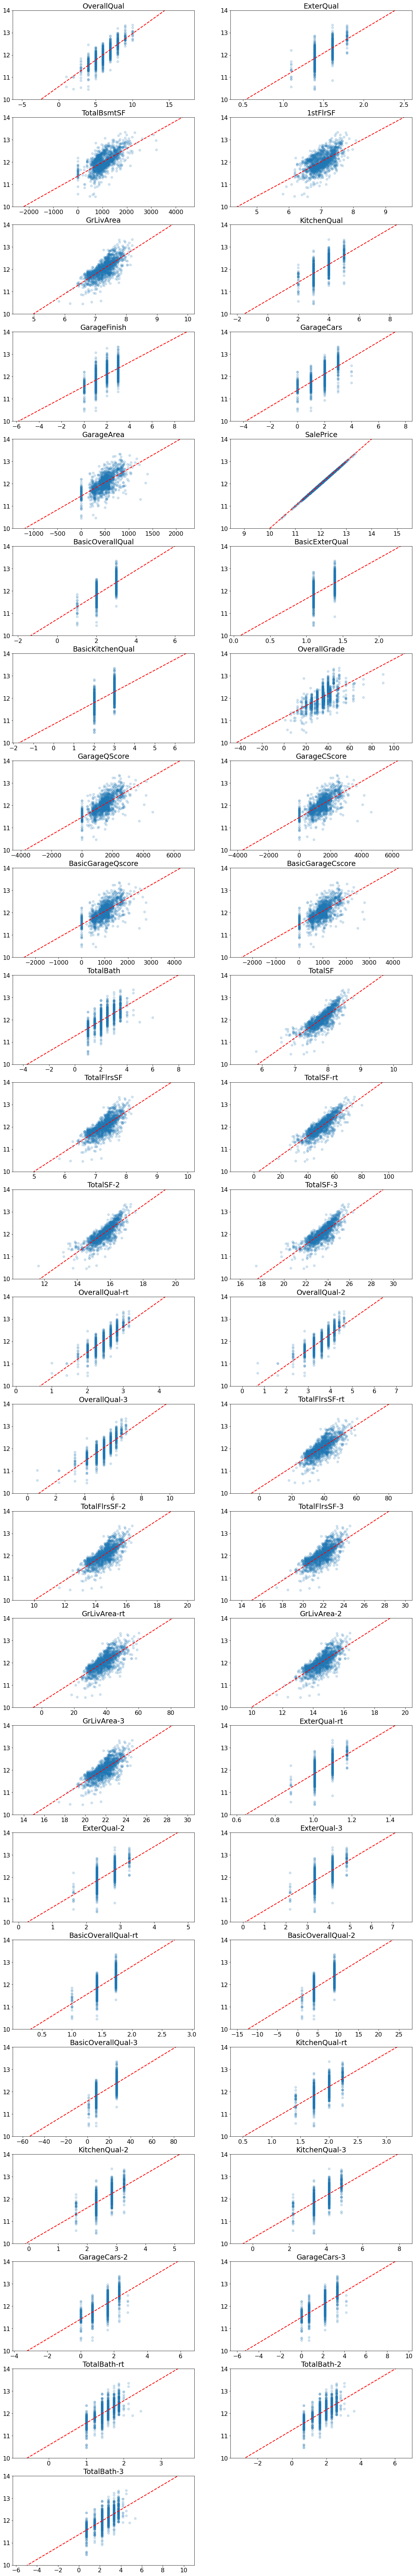

In [21]:
features = list(df_model.columns)
best_features = list()
j=0
fig, axs = plt.subplots(figsize=(16,800))
fig.tight_layout()

for i in range(0,len(features)):
    #r, p = stats.pearsonr(df_model[features[i]],df_model['adjprice'])
    slope, intercept, r, p, std_err = stats.linregress(df_model[features[i]],target)
    if (p < 0.05) & (np.sqrt(r**2) > 0.6):
        #print('{:<4d}{:<25s}{:>10f}{:>12f}'.format(i,features[i],r,p))
        j=j+1
        best_features.append(features[i])
        devs = 9
        xmin = np.mean(df_model[features[i]]) - devs*np.std(df_model[features[i]])
        xmax = np.mean(df_model[features[i]]) + devs*np.std(df_model[features[i]])
        domain = np.linspace(-1e9,1e9,10)
        y_pred = slope*domain + intercept
        plt.subplot(200,2,j)
        plt.xlim(xmin,xmax)
        plt.ylim(10,14)
        plt.scatter(df_model[features[i]],target,alpha=0.2)
        plt.plot(domain,y_pred,c = 'r', linestyle='--',linewidth=2)
        #plt.xticks(rotation=90)
        #plt.text(xmin,10.25,
        #f' $R^2$ = {r:.2f}\
        #\n $ln$(adjprice) =\
        #\n   ({slope:.2e}){features[i]} + {intercept:.2e}\
        #\np = {p:.2e}\nstderr = {std_err:.2e}')
        plt.title(features[i])
print(j)
best_features.remove('SalePrice')


In [22]:
np.expm1(np.log1p(3))

3.0

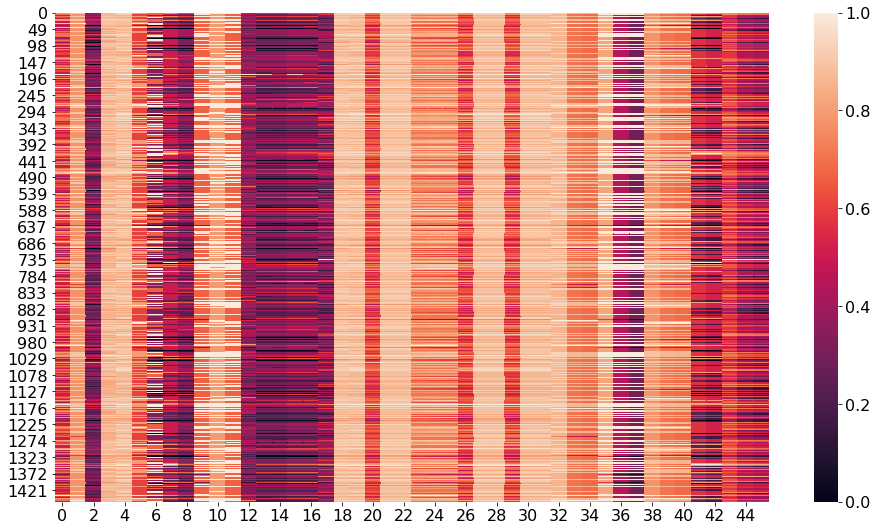

In [23]:
template = np.zeros((df_model.shape[0],df_model.loc[:,best_features].shape[1]+1),dtype=np.float64)
yX_shm = SharedMemory(create=True, size=template.nbytes)
yX = np.ndarray(template.shape, dtype=template.dtype, buffer=yX_shm.buf)

yX[:,1:] = np.array(df_model.loc[:,best_features],dtype=np.float64)[:,:]
yX, normvec = normalize(yX, norm='max', axis=0, return_norm=True)
yX[:,0] = target
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,1:])
plt.show()

In [24]:
# MULTIPROCESSING DEFINITIONS

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY, WORK_INDEX):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[WORK_INDEX]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[WORK_INDEX] - distance
    return work_schedule


def score_model(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    y = INPUT[:,0]
    for i in range(0, DURATION):
        rng = np.random.default_rng()
        state = rng.integers(1e9)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = state)
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        OUTPUT[0][i + OFFSET] = reg.score(X_test,y_test)
        #y_pred = np.expm1(reg.predict(X_test),dtype = np.float64)
        #y_actual = np.apply_along_axis(np.expm1,0,y_test)
        #RMSE = np.sqrt(np.mean(y_pred - y_actual)**2)
        #OUTPUT[1][i + OFFSET] = RMSE


"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT, TASK, MODEL_TYPE, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        #print(f'start {i}')
        p = Process(target=TASK, args=(INPUT,OUTPUT, MODEL_TYPE, WORK_SCHEDULE[i,0], WORK_SCHEDULE[i,1]))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        #print(f'join {i}')
        processes[i].join()

def draw_plots(MODEL_TYPE, WORKOUTPUT, BINS):
    plt.subplots(2,1,figsize=(16,16))
    xlab = ['$R^2$','RMSE\n($USD, adjusted for inflation 2021)']
    xlims = np.array(((-1.0,1.0),
                    (0.0,20000.0)))
    for i in range(0,2):
        plt.subplot(2, 1, i + 1)
        plt.hist(WORKOUTPUT[i],bins=BINS)
        plt.title(f'{str(MODEL_TYPE)} (N={testlen:,})')
        plt.xlabel(xlab[i])
        plt.xlim(xlims[i,0],xlims[i,1])
        plt.ylabel('Frequency')
    plt.show()

    print('========')
    print('Scores ')
    tmp = stats.describe(WORKOUTPUT[0])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'  {tmp._fields[i]}:{buf}\t{tmp[i]}')

    print('========')
    print(' Error  ')
    tmp = stats.describe(WORKOUTPUT[1])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'  {tmp._fields[i]}:{buf}\t{tmp[i]}')

In [25]:
!rm 'firstlinear.pkl'

Go!
Time Elapsed: 168.666s


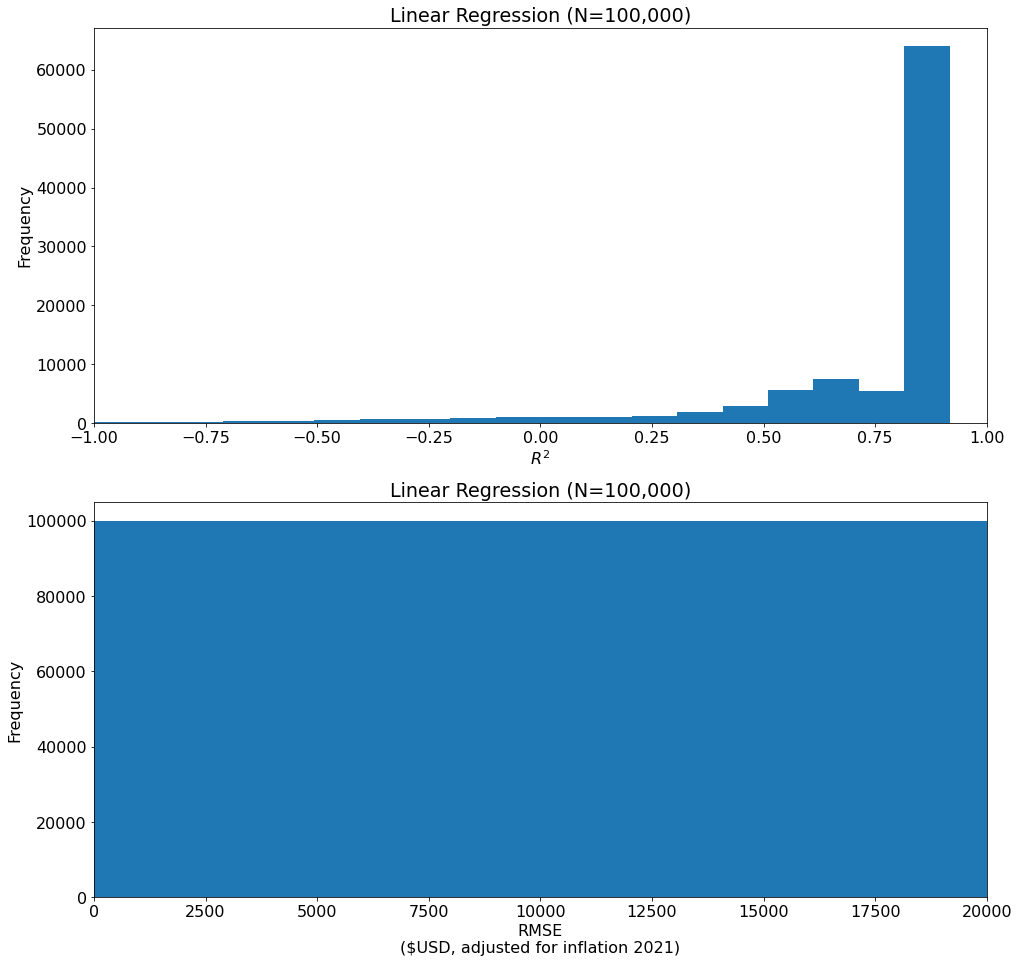

Scores 
  nobs:    	100000
  minmax:  	(-24.501039861472407, 0.9167645329591956)
  mean:    	0.4426602316185286
  variance:	2.0581489713137677
  skewness:	-5.508691517534686
  kurtosis:	34.93582776745333
 Error  
  nobs:    	100000
  minmax:  	(0.05600358759254785, 2.2405940309161437e+17)
  mean:    	3073060581331.403
  variance:	5.436513185647875e+29
  skewness:	287.1981468457641
  kurtosis:	85840.24331900281


In [26]:
filename = 'firstlinear.pkl'
testlen = 100000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
except:
    print('Go!')
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    model = LinearRegression()
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)
    
draw_plots('Linear Regression',output,250)

In [28]:
df_test =  pd.read_csv('./input/test.csv')
df_test.set_index('Id',inplace=True)
df_test.shape

(1459, 79)

In [29]:
# This isn't very elegant. Try to make this less brute forcey, more modular.
# It's a pretty regular task and would benefit from attention.

mean_frontage_ratio = np.mean(df['LotFrontage']/df['LotArea'])
df_test['LotFrontage'].replace(np.nan,mean_frontage_ratio*df_test['LotArea'],inplace=True)
df_test['Alley'].replace(np.nan,'None',inplace=True)
df_test['MasVnrArea'].replace(np.nan,0,inplace=True)
df_test['MasVnrType'].replace(np.nan,'None',inplace=True)
df_test['BsmtQual'].replace(np.nan,'None',inplace=True)
df_test['BsmtCond'].replace(np.nan,'None',inplace=True)
df_test['BsmtExposure'].replace(np.nan,'None',inplace=True)
df_test['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df_test['BsmtFinType2'].replace(np.nan,'None',inplace=True)
df_test['Electrical'].replace(np.nan,'SBrkr',inplace=True)
df_test['FireplaceQu'].replace(np.nan,'None',inplace=True)
df_test['GarageType'].replace(np.nan,'None',inplace=True)
df_test['GarageYrBlt'].replace(np.nan,df['GarageYrBlt'].mean(),inplace=True)
df_test['GarageFinish'].replace(np.nan,'None',inplace=True)
df_test['GarageQual'].replace(np.nan,'None',inplace=True)
df_test['GarageCond'].replace(np.nan,'None',inplace=True)
df_test['PoolQC'].replace(np.nan,'None',inplace=True)
df_test['Fence'].replace(np.nan,'None',inplace=True)
df_test['MiscFeature'].replace(np.nan,'None',inplace=True)
df_test['Exterior2nd'].replace(np.nan,'VinylSd',inplace=True)
df_test['Exterior1st'].replace(np.nan,'VinylSd',inplace=True)
df_test['Utilities'].replace(np.nan,'AllPub',inplace=True)
df_test['LandContour'].replace(np.nan,'Lvl',inplace=True)
df_test['MSZoning'].replace(np.nan,'RL',inplace=True)
df_test['BsmtFinSF1'].replace(np.nan,df['BsmtFinSF1'].mean(),inplace=True)
df_test['BsmtFinSF2'].replace(np.nan,df['BsmtFinSF2'].mean(),inplace=True)
df_test['TotalBsmtSF'].replace(np.nan,df['TotalBsmtSF'].mean(),inplace=True)
df_test['BsmtUnfSF'].replace(np.nan,df['TotalBsmtSF'].mean(),inplace=True)
df_test['BsmtFullBath'].replace(np.nan,stats.mode(df_test.BsmtFullBath)[0][0],inplace=True)
df_test['BsmtHalfBath'].replace(np.nan,stats.mode(df_test.BsmtHalfBath)[0][0],inplace=True)
df_test['KitchenQual'].replace(np.nan,stats.mode(df_test.KitchenQual)[0][0],inplace=True)
df_test['Functional'].replace(np.nan,stats.mode(df_test.Functional)[0][0],inplace=True)
df_test['GarageCars'].replace(np.nan,stats.mode(df_test.GarageCars)[0][0],inplace=True)
df_test['GarageArea'].replace(np.nan,stats.mode(df_test.GarageArea)[0][0],inplace=True)
df_test['SaleType'].replace(np.nan,stats.mode(df_test.SaleType)[0][0],inplace=True)

for column in df_test.columns:
    if df_test[column].isnull().any():
        print(column)

In [30]:
!rm predict.pkl

In [31]:
# Begin by including all features in our model
filename = 'predict.pkl'

try:
    with open(filename,'rb') as f:
        df_predict = pickle.load(f)
except:    
    print('Building new model')
    df_predict = pd.DataFrame(df_test.index)
    df_predict.set_index('Id',inplace=True)

    for i in range(len(categoric)):
        try:
            df_predict = df_predict.join(pd.get_dummies(df_test[categoric[i]],prefix=categoric[i]))
        except:
            continue
    df_cats = pd.DataFrame({'Id':df_test.index})
    df_cats.set_index('Id',inplace=True)
    df_cats = df_test.loc[:,numeric]
    df_predict = df_cats.merge(df_predict, how='inner', left_index=True,right_index=True)
    df_predict = df_predict.loc[:,best_features]
    df_predict = df_predict/normvec[1:]
    with open(filename,'wb') as f:
        pickle.dump(df_predict,f)
df_predict.shape


Building new model


/usr/pkg/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(1459, 71)

In [32]:
X_pred = np.array(df_predict)

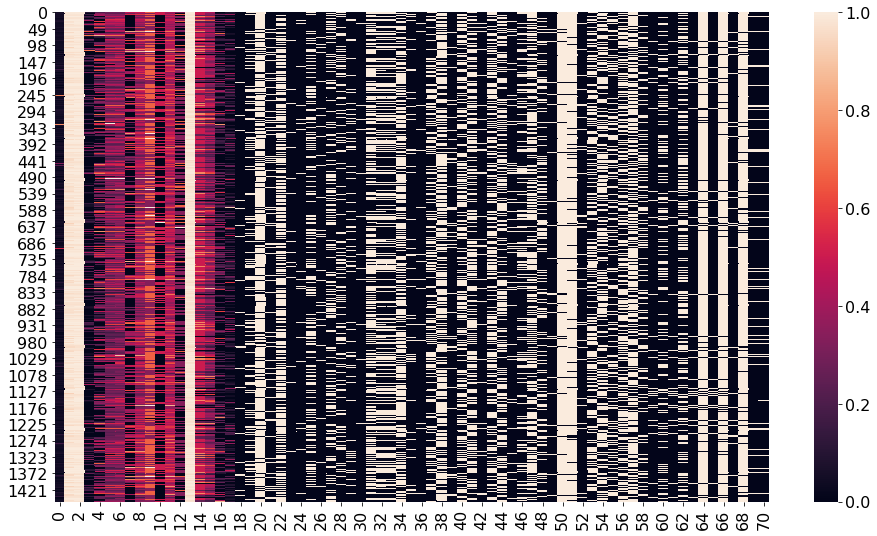

In [33]:
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,1:])
plt.show()

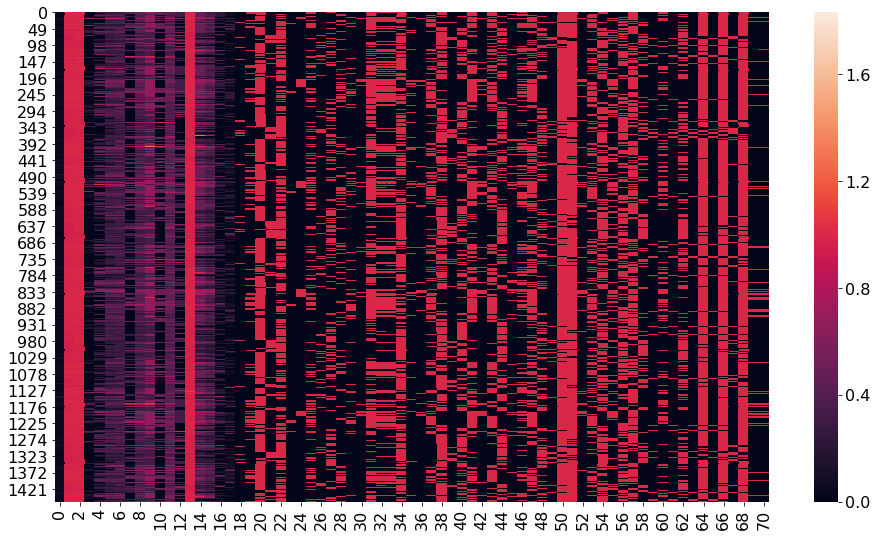

In [34]:
plt.figure(figsize=(16,9))
sns.heatmap(X_pred)
plt.show()

In [53]:
#X_train, X_test, y_train, y_test = train_test_split(yX[:,1:], yX[:,0], test_size=0.2)
GBR = GradientBoostingRegressor(loss='huber', tol=1e-5)
parameters = {'learning_rate': np.arange(0.01,0.3,0.01),
                  #'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : np.arange(100,500,10),
                  'max_depth'    : np.arange(1,5)
                  #'alpha'        : ['']
                 }
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 10, n_jobs=-1)
#grid_GBR.fit(X_train,y_train)
grid_GBR.fit(yX[:,1:], yX[:,0])
print('DONE!')

DONE!


In [54]:
grid_GBR.score(yX[:,1:], yX[:,0])

0.9464647149052408

In [55]:
GBR_best = grid_GBR.best_estimator_
GBR_best

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.08, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=230,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=1e-05,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
"""#X_train, X_test, y_train, y_test = train_test_split(yX[:,1:], yX[:,0], test_size=0.2)
GBR = GradientBoostingRegressor(loss='huber', tol=1e-5)
parameters = {'learning_rate': np.arange(0.01,0.3,0.01),
                  #'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : np.arange(100,500,10),
                  'max_depth'    : np.arange(1,5)
                  #'alpha'        : ['']
                 }
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 10, n_jobs=-1)
#grid_GBR.fit(X_train,y_train)
grid_GBR.fit(yX[:,1:], yX[:,0])
print('DONE!')"""


BestRegress = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.08, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=230,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=1e-05,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [49]:
GBR_best.score(yX[:,1:], yX[:,0])

0.943363266932477

In [233]:
pd.DataFrame(np.exp(grid_GBR.predict(X_pred)))

,0
0,122856.850027
1,138243.050422
2,180315.271583
3,184360.102607
4,180989.126059
...,...
1454,82100.213040
1455,87189.348844
1456,158970.136717
1457,117442.844461


In [51]:
pd.DataFrame(np.exp(grid_GBR.predict(X_pred)))

,0
0,123148.747847
1,154136.636208
2,189291.646806
3,198605.109733
4,179527.494562
...,...
1454,73992.948321
1455,81159.844500
1456,170736.094721
1457,121267.062141


In [56]:
df_submit = pd.DataFrame({'Id':df_test.index})
#df_submit.loc[:,'SalePrice'] = np.exp(np.apply_along_axis(np.mean,0,output))
df_submit.loc[:,'SalePrice'] = np.exp(grid_GBR.predict(X_pred))
df_submit.set_index('Id',inplace=True)
df_submit.to_csv('./submission.csv')

     
df_submit[0:5]

,SalePrice
Id,
1461,123898.393859
1462,154994.988266
1463,199196.899883
1464,195012.306610
1465,186900.910759
